

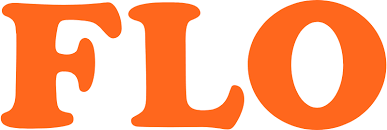

# Unleashing Customer Insights: RFM Analysis & CLTV Prediction for Effective Customer Segmentation

<div style="text-align: justify"> Understanding customer behavior and predicting their future value are crucial factors in designing effective marketing strategies and fostering long-term business success. In this comprehensive project, we embark on a journey through customer segmentation, CLTV prediction, and personalized marketing initiatives. Starting with RFM analysis, leveraging Recency, Frequency, and Monetary Value, valuable insights are unlocked from transactional data provided by FLO company. Through RFM analysis, customers are segmented based on their transaction history and identified distinctive behavioral patterns. Building upon this foundation, further analysis is conducted by employing advanced models like BG-NBD and Gamma-Gamma. These models make it possible to estimate Customer Lifetime Value (CLTV) and gain deeper insights into individual customer value and purchase patterns. By combining the power of RFM analysis and CLTV prediction, businesses are empowered to tailor their marketing efforts and maximize customer engagement. Join me as We navigate through the realm of data-driven customer analytics and uncover actionable strategies for driving business growth and customer loyalty. </div>

### Dataset Information

The dataset consists of information derived from the historical shopping behaviors of customers who made their most recent purchases in the years 2020-2021 through an OmniChannel approach (both online and offline shopping).

- master_id: Unique customer identifier
- order_channel: Indicates the platform/channel used for making the purchase (Android, iOS, Desktop, Mobile, Offline)
- last_order_channel: Represents the channel through which the most recent purchase was made
- first_order_date: The date of the customer's first purchase
- last_order_date: The date of the customer's most recent purchase
- last_order_date_online: The date of the customer's most recent online purchase
- last_order_date_offline: The date of the customer's most recent offline purchase
- order_num_total_ever_online: Total number of purchases made by the customer online
- order_num_total_ever_offline: Total number of purchases made by the customer offline
- customer_value_total_ever_offline: Total amount spent by the customer on offline purchases
- customer_value_total_ever_online: Total amount spent by the customer on online purchases
- interested_in_categories_12: List of categories in which the customer has made purchases in the last 12 months

### Imported Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os, squarify
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Defined Functions

In [4]:
def uniqueInfos(df):
    
    dictz = {"FEATURES": df.columns,
             "N_UNIQUE": [df[item].nunique() for item in df.columns],
             "N_NULL": [df[item].isnull().sum() for item in df.columns],
             "ITEMS": [df[item].unique() for item in df.columns],
             "TYPE" : [df[item].dtype for item in df.columns]}
    
    return pd.DataFrame(data = dictz)


def preprocess_data(data, date_columns): # 1-8
    # Add total_purchases and total_spending variables
    data['total_purchases'] = data['order_num_total_ever_online'] + data['order_num_total_ever_offline']
    data['total_spending'] = data['customer_value_total_ever_online'] + data['customer_value_total_ever_offline']
    
    # Convert date variables to datetime type
    data[date_columns] = data[date_columns].apply(pd.to_datetime)
    
    return data

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return round(low_limit), round(up_limit)


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

## RFM Analysis  

<div style="text-align: justify"> RFM analysis is a customer segmentation technique that plays a crucial role in understanding and effectively targeting customer behavior. By evaluating Recency, Frequency, and Monetary Value, RFM analysis enables businesses to categorize customers into distinct segments based on their engagement and value. This approach provides valuable insights into customer preferences, loyalty, and purchasing patterns. By tailoring marketing strategies to the unique characteristics of each segment, businesses can optimize their efforts, enhance customer retention, and drive growth. RFM analysis serves as a powerful tool for data-driven decision-making and customer-centric marketing strategies in today's competitive business landscape. </div>

In [5]:
csv_list = [file for file in os.listdir(os.getcwd()) if ".csv" in file]
csv_list

['flo_data_20k.csv',
 'indirim_hedef_müşteri_ids.csv',
 'yeni_marka_hedef_müşteri_id.csv']

Let's read the data, take a copy and a glance !

In [6]:
df_ = pd.read_csv(csv_list[0])
df  = df_.copy()

In [7]:
df.head(10) # 1-2a

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,Desktop,Offline,2018-11-18,2021-03-13,2018-11-18,2021-03-13,1.000,2.000,150.870,49.990,[KADIN]
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,Android App,Android App,2020-03-04,2020-10-18,2020-10-18,2020-03-04,3.000,1.000,59.990,315.940,[AKTIFSPOR]
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,Mobile,Offline,2020-05-15,2020-08-12,2020-05-15,2020-08-12,1.000,1.000,49.990,113.640,[COCUK]
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,Android App,Android App,2020-01-23,2021-03-07,2021-03-07,2020-01-25,3.000,2.000,120.480,934.210,"[ERKEK, COCUK, KADIN]"
9,1143f032-440d-11ea-8b43-000d3a38a36f,Mobile,Mobile,2019-07-30,2020-10-04,2020-10-04,2019-07-30,1.000,1.000,69.980,95.980,"[KADIN, AKTIFSPOR]"


Let's print some of the statistical information to know what kind of dataframe we are dealing with!

In [8]:
df.info() #1-2b

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [9]:
df.shape #1-2c

(19945, 12)

In [10]:
df.describe().T #1-2d

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.111,4.226,1.000,1.000,2.000,4.000,200.000
order_num_total_ever_offline,19945.000,1.914,2.063,1.000,1.000,1.000,2.000,109.000
customer_value_total_ever_offline,19945.000,253.923,301.533,10.000,99.990,179.980,319.970,18119.140
customer_value_total_ever_online,19945.000,497.322,832.602,12.990,149.980,286.460,578.440,45220.130


Some of the columns holds datetime values. We need to change their type for RFM and CLTV analysis later on!

In [11]:
uniqueInfos(df) #1-2e_f

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,master_id,19945,0,"[cc294636-19f0-11eb-8d74-000d3a38a36f, f431bd5...",object
1,order_channel,4,0,"[Android App, Desktop, Mobile, Ios App]",object
2,last_order_channel,5,0,"[Offline, Mobile, Android App, Desktop, Ios App]",object
3,first_order_date,2465,0,"[2020-10-30, 2017-02-08, 2019-11-27, 2021-01-0...",object
4,last_order_date,366,0,"[2021-02-26, 2021-02-16, 2020-11-27, 2021-01-1...",object
5,last_order_date_online,1743,0,"[2021-02-21, 2021-02-16, 2020-11-27, 2021-01-1...",object
6,last_order_date_offline,738,0,"[2021-02-26, 2020-01-10, 2019-12-01, 2021-01-0...",object
7,order_num_total_ever_online,57,0,"[4.0, 19.0, 3.0, 1.0, 2.0, 23.0, 7.0, 5.0, 12....",float64
8,order_num_total_ever_offline,32,0,"[1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 6.0, 15....",float64
9,customer_value_total_ever_offline,6097,0,"[139.99, 159.97, 189.97, 39.99, 49.99, 150.87,...",float64


<div style="text-align: justify"> As a step in this project, we will address the concept of OmniChannel, which signifies that customers engage in both online and offline shopping. To capture this behavior, we will create new variables to track the total number of purchases and total expenditure for each customer. These variables will provide insights into the overall shopping activity and spending patterns of the customers across different channels. By considering both online and offline transactions, we can gain a comprehensive understanding of customer behavior and their value to the business. </div>

In [12]:
df['total_purchases'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['total_spending'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

df.head() #1-3

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_purchases,total_spending
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980


Tackle the datetime objects!

In [13]:
dateCols = [item for item in df.columns if "date" in item]
dateCols # 1-4

['first_order_date',
 'last_order_date',
 'last_order_date_online',
 'last_order_date_offline']

In [14]:
df[dateCols] = df[dateCols].apply(pd.to_datetime)
uniqueInfos(df)

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,master_id,19945,0,"[cc294636-19f0-11eb-8d74-000d3a38a36f, f431bd5...",object
1,order_channel,4,0,"[Android App, Desktop, Mobile, Ios App]",object
2,last_order_channel,5,0,"[Offline, Mobile, Android App, Desktop, Ios App]",object
3,first_order_date,2465,0,"[2020-10-30T00:00:00.000000000, 2017-02-08T00:...",datetime64[ns]
4,last_order_date,366,0,"[2021-02-26T00:00:00.000000000, 2021-02-16T00:...",datetime64[ns]
5,last_order_date_online,1743,0,"[2021-02-21T00:00:00.000000000, 2021-02-16T00:...",datetime64[ns]
6,last_order_date_offline,738,0,"[2021-02-26T00:00:00.000000000, 2020-01-10T00:...",datetime64[ns]
7,order_num_total_ever_online,57,0,"[4.0, 19.0, 3.0, 1.0, 2.0, 23.0, 7.0, 5.0, 12....",float64
8,order_num_total_ever_offline,32,0,"[1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 6.0, 15....",float64
9,customer_value_total_ever_offline,6097,0,"[139.99, 159.97, 189.97, 39.99, 49.99, 150.87,...",float64


In [15]:
df.groupby("order_channel")["total_purchases", "total_spending"].agg(["count", "mean", "sum"]) #1-5

total_purchases                 total_spending          \
                        count  mean       sum          count    mean   
order_channel                                                          
Android App              9495 5.505 52269.000           9495 823.493   
Desktop                  2735 3.993 10920.000           2735 588.783   
Ios App                  2833 5.419 15351.000           2833 891.634   
Mobile                   4882 4.441 21679.000           4882 620.275   

                           
                      sum  
order_channel              
Android App   7819062.760  
Desktop       1610321.460  
Ios App       2525999.930  
Mobile        3028183.160

Lets look at the top ten frequent buyers and heavy shoppers!

In [16]:
df.sort_values(by = "total_spending", ascending = False).head(10) #1-6

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_purchases,total_spending
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.000,2.000,684.970,45220.130,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",202.000,45905.100
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,Android App,Android App,2018-08-06,2021-02-23,2021-02-23,2020-07-06,67.000,1.000,130.490,36687.800,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",68.000,36818.290
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.000,1.000,1263.760,32654.340,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",82.000,33918.100
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,Ios App,Offline,2021-03-01,2021-04-13,2021-03-18,2021-04-13,10.000,1.000,538.940,30688.470,"[ERKEK, KADIN, AKTIFSPOR]",11.000,31227.410
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,Android App,Offline,2021-04-07,2021-04-27,2021-04-07,2021-04-27,1.000,3.000,18119.140,2587.200,[AKTIFSPOR],4.000,20706.340
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.000,4.000,843.680,17599.890,"[ERKEK, KADIN, AKTIFSPOR]",70.000,18443.570
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.000,1.000,82.480,16836.090,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",70.000,16918.570
163,fef57ffa-aae6-11e9-a2fc-000d3a38a36f,Mobile,Desktop,2016-11-08,2021-05-12,2021-05-12,2020-07-09,36.000,1.000,180.730,12545.370,"[ERKEK, AKTIFSPOR]",37.000,12726.100
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.000,1.000,49.990,12232.250,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",131.000,12282.240
18767,fc0ce7a4-9d87-11e9-9897-000d3a38a36f,Desktop,Desktop,2018-11-24,2020-11-11,2020-11-11,2019-12-06,18.000,2.000,64.970,12038.180,"[ERKEK, KADIN]",20.000,12103.150


In [17]:
df.sort_values(by = "total_purchases", ascending = False).head(10) #1-7

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_purchases,total_spending
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.000,2.000,684.970,45220.130,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",202.000,45905.100
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.000,1.000,49.990,12232.250,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",131.000,12282.240
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,Android App,Offline,2019-08-07,2020-11-04,2020-09-07,2020-11-04,2.000,109.000,10239.460,143.980,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",111.000,10383.440
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,Android App,Offline,2018-10-18,2020-06-30,2018-10-18,2020-06-30,1.000,87.000,8432.250,139.980,[ERKEK],88.000,8572.230
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,Ios App,Ios App,2019-02-14,2021-04-05,2021-04-05,2020-02-17,2.000,81.000,3997.550,242.810,[ERKEK],83.000,4240.360
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.000,1.000,1263.760,32654.340,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",82.000,33918.100
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2019-02-11,2021-02-11,2021-02-11,2020-12-24,3.000,74.000,4640.770,543.280,"[KADIN, AKTIFSPOR]",77.000,5184.050
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2015-09-12,2021-04-01,2021-04-01,2019-10-08,72.000,3.000,292.930,5004.950,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",75.000,5297.880
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.000,1.000,82.480,16836.090,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",70.000,16918.570
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.000,4.000,843.680,17599.890,"[ERKEK, KADIN, AKTIFSPOR]",70.000,18443.570


Run this if you want all preprocessing done via a function!

In [18]:
df = preprocess_data(df, dateCols)
df.head() # 1-8

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_purchases,total_spending
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980


### Calculating RFM Metrics

To calculate RFM Metrics we choose an analysis date two days after the latest last order date in the dataframe!

In [19]:
analysis_date = df["last_order_date"].max() + dt.timedelta(days=2)
analysis_date

Timestamp('2021-06-01 00:00:00')

To calculate the metrics, we need how recent a customer made an order, how frequently is the customer purchasing and their total expenditure!

In [20]:
rfm = df.groupby('master_id').agg({'last_order_date': lambda last_order_date: (analysis_date - last_order_date.max()).days,
                                   'total_purchases': lambda total_purchases: total_purchases,
                                   'total_spending':  lambda total_spending: total_spending.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']

rfm = rfm[rfm["monetary"] > 0]

rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,19945.000,134.458,103.281,2.000,43.000,111.000,202.000,367.000
frequency,19945.000,5.025,4.743,2.000,3.000,4.000,6.000,202.000
monetary,19945.000,751.244,895.402,44.980,339.980,545.270,897.780,45905.100


In [21]:
rfm.head()

,recency,frequency,monetary
master_id,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,10,5.000,776.070
00034aaa-a838-11e9-a2fc-000d3a38a36f,298,3.000,269.470
000be838-85df-11ea-a90b-000d3a38a36f,213,4.000,722.690
000c1fe2-a8b7-11ea-8479-000d3a38a36f,27,7.000,874.160
000f5e3e-9dde-11ea-80cd-000d3a38a36f,20,7.000,1620.330


### Calculating RFM Scores

Let's rank the scores, 5 being the highest, 1 being the lowest score.

In [22]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))

rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE
master_id,,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,10,5.000,776.070,5,4,4,54
00034aaa-a838-11e9-a2fc-000d3a38a36f,298,3.000,269.470,1,2,1,12
000be838-85df-11ea-a90b-000d3a38a36f,213,4.000,722.690,2,3,4,23
000c1fe2-a8b7-11ea-8479-000d3a38a36f,27,7.000,874.160,5,4,4,54
000f5e3e-9dde-11ea-80cd-000d3a38a36f,20,7.000,1620.330,5,4,5,54


### Customer Segmentation

<div style="text-align: justify"> Customer segmentation is crucial for businesses as it enables targeted marketing, efficient resource allocation, and improved customer retention. By identifying distinct customer groups with similar characteristics, businesses can tailor their marketing efforts to meet the specific needs of each segment, resulting in more effective campaigns and higher customer engagement. Additionally, by allocating resources strategically based on segment value, businesses can optimize their operations and maximize returns, while implementing personalized strategies for at-risk customers helps improve retention and foster long-term loyalty. So we are going to segment the customers in ten categories. </div>

In [23]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)
rfm.tail()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
master_id,,,,,,,,
fff1db94-afd9-11ea-b736-000d3a38a36f,183,5.000,796.870,2,4,4,24,at_Risk
fff4736a-60a4-11ea-8dd8-000d3a38a36f,67,2.000,318.870,4,2,2,42,potential_loyalists
fffacd34-ae14-11e9-a2fc-000d3a38a36f,257,6.000,983.920,1,4,4,14,at_Risk
fffacecc-ddc3-11e9-a848-000d3a38a36f,132,9.000,1362.200,3,5,5,35,loyal_customers
fffe4b30-18e0-11ea-9213-000d3a38a36f,321,4.000,524.690,1,4,3,14,at_Risk


In [24]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "max"]) # 5-1

recency      frequency         monetary          
                       mean  max      mean     max     mean       max
segment                                                              
about_to_sleep      114.032  145     2.407   3.000  361.649  1607.450
at_Risk             242.329  367     4.470   7.000  648.325  3615.670
cant_loose          235.159  367    10.717 111.000 1481.652 12103.150
champions            17.142   33     8.965 202.000 1410.709 45905.100
hibernating         247.426  367     2.391   3.000  362.583  2533.040
loyal_customers      82.558  145     8.356  83.000 1216.257 36818.290
need_attention      113.037  145     3.739   4.000  553.437  4361.440
new_customers        17.976   33     2.000   2.000  344.049  1725.380
potential_loyalists  36.870   83     3.311   4.000  533.741 20706.340
promising            58.695   83     2.000   2.000  334.153  1357.320

In [25]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,19945.000,134.458,103.281,2.000,43.000,111.000,202.000,367.000
frequency,19945.000,5.025,4.743,2.000,3.000,4.000,6.000,202.000
monetary,19945.000,751.244,895.402,44.980,339.980,545.270,897.780,45905.100


In [26]:
df_final = df.merge(rfm, on="master_id", how="left")
df_final.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_purchases,total_spending,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370,95,5.000,939.370,3,4,4,34,loyal_customers
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550,105,21.000,2013.550,3,5,5,35,loyal_customers
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320,186,5.000,585.320,2,4,3,24,at_Risk
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970,135,2.000,121.970,3,1,1,31,about_to_sleep
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980,86,2.000,209.980,3,1,1,31,about_to_sleep


<Axes: xlabel='Count', ylabel='segment'>

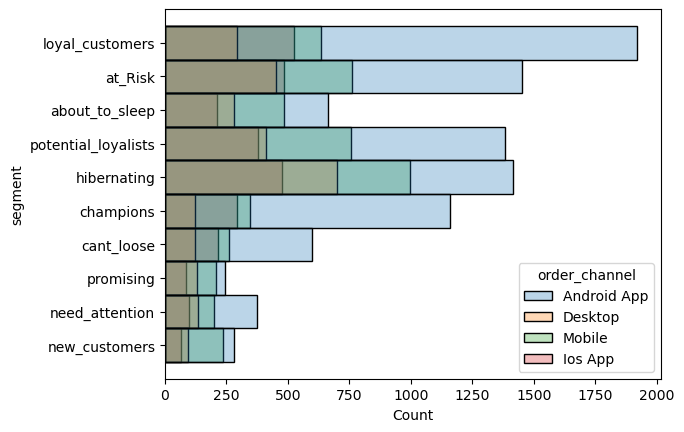

In [27]:
sns.histplot(data = df_final, y = "segment", hue = "order_channel", alpha = 0.3)

The target customer segments for the new women's shoe brand at FLO are planned to be loyal customers who primarily purchase from the women's category and are willing to pay higher prices. To identify these segments, RFM analysis and other customer behavior attributes can be utilized. By leveraging RFM analysis and considering customer interests, the brand can effectively communicate and market its products to these target customer segments.

In [28]:
df_final[(df_final["interested_in_categories_12"].str.contains("KADIN", na=False)) &
         (df_final["segment"].str.contains("champions", na = False)) |
         (df_final["segment"].str.contains("loyal_customer", na = False))] #.master_id.to_csv("yeni_marka_hedef_müşteri_id.csv")

 # 5-2a

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_purchases,total_spending,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370,95,5.000,939.370,3,4,4,34,loyal_customers
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550,105,21.000,2013.550,3,5,5,35,loyal_customers
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,Android App,Android App,2020-01-23,2021-03-07,2021-03-07,2020-01-25,3.000,2.000,120.480,934.210,"[ERKEK, COCUK, KADIN]",5.000,1054.690,86,5.000,1054.690,3,4,5,34,loyal_customers
11,c2e15af2-9eed-11e9-9897-000d3a38a36f,Android App,Android App,2015-07-05,2021-05-19,2021-05-19,2020-07-10,19.000,1.000,90.490,2771.110,"[COCUK, KADIN, AKTIFSPOR]",20.000,2861.600,13,20.000,2861.600,5,5,5,55,champions
17,efb82ba4-aaba-11e9-a2fc-000d3a38a36f,Ios App,Ios App,2019-07-10,2021-01-20,2021-01-20,2019-07-10,2.000,2.000,428.970,459.890,"[ERKEK, AKTIFSPOR]",4.000,888.860,132,4.000,888.860,3,4,4,34,loyal_customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19921,1b18778e-aa04-11e9-a2fc-000d3a38a36f,Mobile,Desktop,2016-06-01,2021-04-23,2021-04-23,2019-08-27,8.000,1.000,169.980,1575.500,[AKTIFSPOR],9.000,1745.480,39,9.000,1745.480,4,5,5,45,loyal_customers
19922,ba5cd8c2-b142-11e9-9757-000d3a38a36f,Ios App,Offline,2018-10-13,2021-03-13,2020-05-12,2021-03-13,10.000,1.000,17.990,1480.460,[ERKEK],11.000,1498.450,80,11.000,1498.450,4,5,5,45,loyal_customers
19926,7e1c15be-6298-11ea-9861-000d3a38a36f,Android App,Android App,2019-02-16,2021-05-22,2021-05-22,2020-03-06,6.000,2.000,310.700,1062.390,"[KADIN, AKTIFSPOR]",8.000,1373.090,10,8.000,1373.090,5,5,5,55,champions
19931,c81bac06-b1f4-11e9-89fa-000d3a38a36f,Android App,Android App,2019-07-23,2021-04-07,2021-04-07,2020-02-12,7.000,2.000,99.980,1081.740,"[COCUK, AKTIFSPOR]",9.000,1181.720,55,9.000,1181.720,4,5,5,45,loyal_customers


In [29]:
df_final[(df_final["segment"].str.contains("cant_loose", na = False)) |
         (df_final["segment"].str.contains("hibernating", na = False)) |
         (df_final["segment"].str.contains("new_customers", na = False))]#.master_id.to_csv("indirim_hedef_müşteri_ids.csv")

 # 5-3a

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_purchases,total_spending,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,Mobile,Offline,2020-05-15,2020-08-12,2020-05-15,2020-08-12,1.000,1.000,49.990,113.640,[COCUK],2.000,163.630,293,2.000,163.630,1,1,1,11,hibernating
9,1143f032-440d-11ea-8b43-000d3a38a36f,Mobile,Mobile,2019-07-30,2020-10-04,2020-10-04,2019-07-30,1.000,1.000,69.980,95.980,"[KADIN, AKTIFSPOR]",2.000,165.960,240,2.000,165.960,1,1,1,11,hibernating
10,ae608ece-c9d8-11ea-a31e-000d3a38a36f,Ios App,Offline,2020-07-19,2020-07-25,2020-07-19,2020-07-25,1.000,1.000,74.990,39.990,"[AKTIFCOCUK, COCUK, KADIN]",2.000,114.980,311,2.000,114.980,1,1,1,11,hibernating
15,13ed97a4-b167-11e9-89fa-000d3a38a36f,Mobile,Desktop,2019-06-13,2020-08-17,2020-08-17,2020-07-28,7.000,1.000,112.970,819.390,"[AKTIFCOCUK, COCUK, KADIN]",8.000,932.360,288,8.000,932.360,1,5,4,15,cant_loose
19,2730793e-3908-11ea-85d6-000d3a38a36f,Mobile,Mobile,2019-07-29,2020-06-19,2020-06-19,2019-07-29,1.000,1.000,34.990,279.990,[ERKEK],2.000,314.980,347,2.000,314.980,1,1,2,11,hibernating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19934,9777eb76-bed4-11ea-958c-000d3a38a36f,Desktop,Offline,2020-07-05,2020-12-02,2020-11-28,2020-12-02,1.000,2.000,390.960,143.990,"[ERKEK, KADIN]",3.000,534.950,181,3.000,534.950,2,2,3,22,hibernating
19936,1982ac0e-9f4c-11e9-9897-000d3a38a36f,Android App,Android App,2019-02-08,2020-06-28,2020-06-28,2019-09-28,10.000,2.000,149.980,1468.240,[AKTIFCOCUK],12.000,1618.220,338,12.000,1618.220,1,5,5,15,cant_loose
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,Android App,Offline,2019-09-21,2020-07-05,2020-06-05,2020-07-05,1.000,2.000,289.980,111.980,"[ERKEK, AKTIFSPOR]",3.000,401.960,331,3.000,401.960,1,2,2,12,hibernating
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,Desktop,Desktop,2020-03-01,2020-12-22,2020-12-22,2020-03-01,1.000,1.000,150.480,239.990,[AKTIFSPOR],2.000,390.470,161,2.000,390.470,2,1,2,21,hibernating


## CLTV Prediction with BG-NBD & Gamma-Gamma Models

<div style="text-align: justify"> This part focuses on Customer Lifetime Value (CLTV) prediction using advanced models, specifically the BG-NBD and Gamma-Gamma models. CLTV estimation plays a vital role in strategic decision-making and customer-centric marketing. Building upon the earlier RFM analysis, which segmented customers based on Recency, Frequency, and Monetary Value, this project aims to delve deeper into predicting future customer value. The BG-NBD model allows for the estimation of future purchasing probabilities and customer churn rates, while the Gamma-Gamma model enables analysis of customer transaction values. By harnessing the power of these models, this project aims to provide actionable insights for businesses to optimize marketing efforts, maximize customer lifetime value, and foster long-term customer loyalty. </div>

In [30]:
df = df_.copy()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.111,4.226,1.000,1.000,2.000,4.000,200.000
order_num_total_ever_offline,19945.000,1.914,2.063,1.000,1.000,1.000,2.000,109.000
customer_value_total_ever_offline,19945.000,253.923,301.533,10.000,99.990,179.980,319.970,18119.140
customer_value_total_ever_online,19945.000,497.322,832.602,12.990,149.980,286.460,578.440,45220.130


In [31]:
colsToSuppress =  df.select_dtypes(include='float').columns.tolist()
colsToSuppress

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online']

In [32]:
for item in colsToSuppress:
    replace_with_thresholds(df, item)

df = preprocess_data(df, dateCols)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,2.000,4.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,2.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,99.990,179.980,319.970,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,149.980,286.460,578.440,7800.000
total_purchases,19945.000,4.978,4.121,2.000,3.000,4.000,6.000,57.000
total_spending,19945.000,741.627,687.906,44.980,339.980,545.270,897.780,9063.760


In [33]:
uniqueInfos(df)

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,master_id,19945,0,"[cc294636-19f0-11eb-8d74-000d3a38a36f, f431bd5...",object
1,order_channel,4,0,"[Android App, Desktop, Mobile, Ios App]",object
2,last_order_channel,5,0,"[Offline, Mobile, Android App, Desktop, Ios App]",object
3,first_order_date,2465,0,"[2020-10-30T00:00:00.000000000, 2017-02-08T00:...",datetime64[ns]
4,last_order_date,366,0,"[2021-02-26T00:00:00.000000000, 2021-02-16T00:...",datetime64[ns]
5,last_order_date_online,1743,0,"[2021-02-21T00:00:00.000000000, 2021-02-16T00:...",datetime64[ns]
6,last_order_date_offline,738,0,"[2021-02-26T00:00:00.000000000, 2020-01-10T00:...",datetime64[ns]
7,order_num_total_ever_online,46,0,"[4.0, 19.0, 3.0, 1.0, 2.0, 23.0, 7.0, 5.0, 12....",float64
8,order_num_total_ever_offline,16,0,"[1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 16.0, 6.0, 15....",float64
9,customer_value_total_ever_offline,6081,0,"[139.99, 159.97, 189.97, 39.99, 49.99, 150.87,...",float64


We are going to calculate the recency and tenure (T) as weeks!

In [34]:
cltv_df = pd.DataFrame()
cltv_df["recency"] = (df["last_order_date"] - df["first_order_date"]) 
cltv_df["recency_cltv_weekly"] = cltv_df["recency"].apply(lambda x: x.days) / 7
cltv_df["T"] = (analysis_date - df["first_order_date"])
cltv_df["T_weekly"] = cltv_df["T"].apply(lambda x: x.days) / 7
cltv_df["frequency"] = df["total_purchases"]
cltv_df["monetary_cltv_avg"]  = df["total_spending"] / cltv_df["frequency"]

cltv_df["customer_id"] = df["master_id"]
cltv_df = cltv_df.drop("recency T".split(), axis = 1)

cltv_df.head()

,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,customer_id
0,17.000,30.571,5.000,187.874,cc294636-19f0-11eb-8d74-000d3a38a36f
1,209.857,224.857,21.000,95.883,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f
2,52.286,78.857,5.000,117.064,69b69676-1a40-11ea-941b-000d3a38a36f
3,1.571,20.857,2.000,60.985,1854e56c-491f-11eb-806e-000d3a38a36f
4,83.143,95.429,2.000,104.990,d6ea1074-f1f5-11e9-9346-000d3a38a36f


In [35]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19945.000,95.263,74.589,0.000,50.429,76.571,109.429,433.429
T_weekly,19945.000,114.472,74.771,0.714,73.857,93.000,119.429,437.143
frequency,19945.000,4.978,4.121,2.000,3.000,4.000,6.000,57.000
monetary_cltv_avg,19945.000,152.099,73.524,22.490,103.653,136.906,182.450,1401.800


In [36]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

/home/sadi/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [37]:
cltv_df["exp_sales_3_month"] = bgf.predict(12,
                                           cltv_df['frequency'],
                                           cltv_df['recency_cltv_weekly'],
                                           cltv_df['T_weekly'])

cltv_df.sort_values(by = "exp_sales_3_month", ascending = False).head(5)

,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,customer_id,exp_sales_3_month
7330,62.714,67.286,52.000,166.225,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,4.656
15611,39.714,40.000,29.000,165.298,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,3.374
8328,28.857,33.286,25.000,97.440,1902bf80-0035-11eb-8341-000d3a38a36f,3.142
19538,52.571,58.714,31.000,228.530,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,3.084
14373,38.000,46.429,27.000,141.355,f00ad516-c4f4-11ea-98f7-000d3a38a36f,3.001


In [38]:
cltv_df["exp_sales_6_month"] = bgf.predict(24,
                                           cltv_df['frequency'],
                                           cltv_df['recency_cltv_weekly'],
                                           cltv_df['T_weekly'])

cltv_df.sort_values(by = "exp_sales_6_month", ascending = False).head(5)

,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,customer_id,exp_sales_3_month,exp_sales_6_month
7330,62.714,67.286,52.000,166.225,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,4.656,9.312
15611,39.714,40.000,29.000,165.298,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,3.374,6.748
8328,28.857,33.286,25.000,97.440,1902bf80-0035-11eb-8341-000d3a38a36f,3.142,6.285
19538,52.571,58.714,31.000,228.530,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,3.084,6.168
14373,38.000,46.429,27.000,141.355,f00ad516-c4f4-11ea-98f7-000d3a38a36f,3.001,6.003


In [39]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])


<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [40]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary_cltv_avg'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(5)

,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,customer_id,exp_sales_3_month,exp_sales_6_month,expected_average_profit
9055,2.857,7.857,4.000,1401.800,47a642fe-975b-11eb-8c2a-000d3a38a36f,1.094,2.189,1449.060
17323,51.714,101.000,7.000,1106.467,f59053e2-a503-11e9-a2fc-000d3a38a36f,0.722,1.444,1127.612
15516,63.571,83.857,4.000,1090.360,9083981a-f59e-11e9-841e-000d3a38a36f,0.575,1.149,1127.354
6402,8.286,9.429,2.000,862.690,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,0.794,1.588,923.680
16410,57.000,94.857,2.000,859.580,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,0.397,0.795,920.358


In [41]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,  # 6 months
                                   freq="W",  # T frequency as weeks
                                   discount_rate=0.01)

In [42]:
cltv_df["cltv"] = cltv
cltv_df.sort_values(by="cltv", ascending=False).head(20)

,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,customer_id,exp_sales_3_month,exp_sales_6_month,expected_average_profit,cltv
9055,2.857,7.857,4.000,1401.800,47a642fe-975b-11eb-8c2a-000d3a38a36f,1.094,2.189,1449.060,3327.777
13880,6.143,13.143,11.000,758.085,7137a5c0-7aad-11ea-8f20-000d3a38a36f,1.970,3.940,767.361,3172.394
17323,51.714,101.000,7.000,1106.467,f59053e2-a503-11e9-a2fc-000d3a38a36f,0.722,1.444,1127.612,1708.982
12438,74.286,74.571,16.000,501.874,625f40a2-5bd2-11ea-98b0-000d3a38a36f,1.565,3.131,506.167,1662.613
7330,62.714,67.286,52.000,166.225,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,4.656,9.312,166.712,1628.887
8868,3.429,34.429,8.000,601.226,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,1.265,2.531,611.493,1623.813
6402,8.286,9.429,2.000,862.690,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,0.794,1.588,923.680,1538.856
6666,9.714,13.000,17.000,259.865,53fe00d4-7b7a-11eb-960b-000d3a38a36f,2.781,5.561,262.073,1529.228
19538,52.571,58.714,31.000,228.530,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,3.084,6.168,229.607,1485.819
14858,14.857,15.571,3.000,743.587,031b2954-6d28-11eb-99c4-000d3a38a36f,0.872,1.743,778.050,1423.000


In [43]:
cltv_df["segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

cltv_df.sort_values(by="cltv", ascending=False).head(50)


,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,customer_id,exp_sales_3_month,exp_sales_6_month,expected_average_profit,cltv,segment
9055,2.857,7.857,4.000,1401.800,47a642fe-975b-11eb-8c2a-000d3a38a36f,1.094,2.189,1449.060,3327.777,A
13880,6.143,13.143,11.000,758.085,7137a5c0-7aad-11ea-8f20-000d3a38a36f,1.970,3.940,767.361,3172.394,A
17323,51.714,101.000,7.000,1106.467,f59053e2-a503-11e9-a2fc-000d3a38a36f,0.722,1.444,1127.612,1708.982,A
12438,74.286,74.571,16.000,501.874,625f40a2-5bd2-11ea-98b0-000d3a38a36f,1.565,3.131,506.167,1662.613,A
7330,62.714,67.286,52.000,166.225,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,4.656,9.312,166.712,1628.887,A
8868,3.429,34.429,8.000,601.226,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,1.265,2.531,611.493,1623.813,A
6402,8.286,9.429,2.000,862.690,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,0.794,1.588,923.680,1538.856,A
6666,9.714,13.000,17.000,259.865,53fe00d4-7b7a-11eb-960b-000d3a38a36f,2.781,5.561,262.073,1529.228,A
19538,52.571,58.714,31.000,228.530,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,3.084,6.168,229.607,1485.819,A
14858,14.857,15.571,3.000,743.587,031b2954-6d28-11eb-99c4-000d3a38a36f,0.872,1.743,778.050,1423.000,A


In [44]:
cltv_df.groupby("segment").agg({"count", "mean", "sum"})

recency_cltv_weekly                  T_weekly                   \
                       mean        sum count     mean        sum count   
segment                                                                  
D                   139.000 693193.857  4987  162.183 808807.714  4987   
C                    92.630 461850.857  4986  112.818 562512.143  4986   
B                    81.988 408794.000  4986  100.327 500228.000  4986   
A                    67.427 336191.714  4986   82.550 411592.857  4986   

        frequency                 monetary_cltv_avg                    \
             mean       sum count              mean         sum count   
segment                                                                 
D           3.769 18795.000  4987            93.152  464547.046  4987   
C           4.405 21962.000  4986           125.789  627181.647  4986   
B           5.093 25392.000  4986           160.637  800933.959  4986   
A           6.647 33140.000  4986           228.831 1140952.075  4986   

        exp_sales_3_month                exp_sales_6_month                 \
                     mean      sum count              mean      sum count   
segment                                                                     
D                   0.409 2039.164  4987             0.818 4078.328  4987   
C                   0.525 2619.885  4986             1.051 5239.769  4986   
B                   0.601 2997.110  4986             1.202 5994.219  4986   
A                   0.773 3854.313  4986             1.546 7708.626  4986   

        expected_average_profit                      cltv                    
                           mean         sum count    mean         sum count  
segment                                                                      
D                        98.691  492172.441  4987  80.340  400657.955  4987  
C                       132.251  659401.453  4986 138.312  689621.178  4986  
B                       168.001  837650.882  4986 199.533  994870.784  4986  
A                       238.024 1186787.639  4986 362.316 1806505.089  4986

In [45]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19945.000,95.263,74.589,0.000,50.429,76.571,109.429,433.429
T_weekly,19945.000,114.472,74.771,0.714,73.857,93.000,119.429,437.143
frequency,19945.000,4.978,4.121,2.000,3.000,4.000,6.000,57.000
monetary_cltv_avg,19945.000,152.099,73.524,22.490,103.653,136.906,182.450,1401.800
exp_sales_3_month,19945.000,0.577,0.231,0.149,0.434,0.535,0.670,4.656
exp_sales_6_month,19945.000,1.154,0.463,0.299,0.868,1.071,1.340,9.312
expected_average_profit,19945.000,159.239,77.019,25.083,108.771,142.917,190.446,1449.060
cltv,19945.000,195.119,132.878,12.108,112.245,165.469,240.058,3327.777


In [46]:
cltv_df.to_csv("cltv_final.csv")